# Prostate Cancer Project
# Metastasis Prediction Using mRNA Expression Data 
# Feature Selection 3rd Step - ReliefF

## Import Library

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC

## Import Function

In [3]:
def read_object(obj_path):
    with open(obj_path, 'rb') as input:
        return pickle.load(input)

def save_object(obj, dir_path, file_name, file_extension='pkl', create_dir=True):
    if create_dir:
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
    name = os.path.normpath(os.path.join(dir_path, file_name+'.'+file_extension))
    with open(name, 'wb') as output:  # overwrites any existing file
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        return name

In [4]:
from sklearn.metrics.pairwise import pairwise_distances


def reliefF(X, y, **kwargs):
    """
    This function implements the reliefF feature selection

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        parameters of reliefF:
        k: {int}
            choices for the number of neighbors (default k = 5)

    Output
    ------
    score: {numpy array}, shape (n_features,)
        reliefF score for each feature

    Reference
    ---------
    Robnik-Sikonja, Marko et al. "Theoretical and empirical analysis of relieff and rrelieff." Machine Learning 2003.
    Zhao, Zheng et al. "On Similarity Preserving Feature Selection." TKDE 2013.
    """

    if "k" not in kwargs.keys():
        k = 5
    else:
        k = kwargs["k"]
    n_samples, n_features = X.shape

    # calculate pairwise distances between instances
    distance = pairwise_distances(X, metric='manhattan')

    score = np.zeros(n_features)

    # the number of sampled instances is equal to the number of total instances
    for idx in range(n_samples):
        near_hit = []
        near_miss = dict()

        self_fea = X[idx, :]
        c = np.unique(y).tolist()

        stop_dict = dict()
        for label in c:
            stop_dict[label] = 0
        del c[c.index(y[idx])]

        p_dict = dict()
        p_label_idx = float(len(y[y == y[idx]]))/float(n_samples)

        for label in c:
            p_label_c = float(len(y[y == label]))/float(n_samples)
            p_dict[label] = p_label_c/(1-p_label_idx)
            near_miss[label] = []

        distance_sort = []
        distance[idx, idx] = np.max(distance[idx, :])

        for i in range(n_samples):
            distance_sort.append([distance[idx, i], int(i), y[i]])
        distance_sort.sort(key=lambda x: x[0])

        for i in range(n_samples):
            # find k nearest hit points
            if distance_sort[i][2] == y[idx]:
                if len(near_hit) < k:
                    near_hit.append(distance_sort[i][1])
                elif len(near_hit) == k:
                    stop_dict[y[idx]] = 1
            else:
                # find k nearest miss points for each label
                if len(near_miss[distance_sort[i][2]]) < k:
                    near_miss[distance_sort[i][2]].append(distance_sort[i][1])
                else:
                    if len(near_miss[distance_sort[i][2]]) == k:
                        stop_dict[distance_sort[i][2]] = 1
            stop = True
            for (key, value) in stop_dict.items():
                    if value != 1:
                        stop = False
            if stop:
                break

        # update reliefF score
        near_hit_term = np.zeros(n_features)
        for ele in near_hit:
            near_hit_term = np.array(abs(self_fea-X[ele, :]))+np.array(near_hit_term)

        near_miss_term = dict()
        for (label, miss_list) in near_miss.items():
            near_miss_term[label] = np.zeros(n_features)
            for ele in miss_list:
                near_miss_term[label] = np.array(abs(self_fea-X[ele, :]))+np.array(near_miss_term[label])
            score += near_miss_term[label]/(k*p_dict[label])
        score -= near_hit_term/k
    return score


def feature_ranking(score):
    """
    Rank features in descending order according to reliefF score, the higher the reliefF score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

## Loading and Preparing Train and Test Data Matrix and Target Vector

In [6]:
dir_path = 'D:/VSCodes (Saeed)/Prostate Cancer Project (Metastasis Status)(mRNA)/Preprocessing_Step/'

file_name = 'Train Matrix.pkl'
train_matrix =read_object(dir_path+file_name)

file_name = 'Test Matrix.pkl'
test_matrix =read_object(dir_path+file_name)

file_name = 'Train Target.pkl'
train_target =read_object(dir_path+file_name)

file_name = 'Test Target.pkl'
test_target =read_object(dir_path+file_name)

dir_path = 'D:/VSCodes (Saeed)/Prostate Cancer Project (Metastasis Status)(mRNA)/Reading_Step/'

file_name = 'mRNA ID.pkl'
mRNA_id = read_object(dir_path + file_name)

dir_path = 'D:/VSCodes (Saeed)/Prostate Cancer Project (Metastasis Status)(mRNA)/Feature_Selection_Step/'

file_name = 'Selected Features (2nd step).pkl'
mRNA_id_prime = read_object(dir_path + file_name)

In [7]:
train_samples_num = train_matrix.shape[0]
test_samples_num = test_matrix.shape[0]
features_num = len(mRNA_id_prime)
train_matrix_prime = np.zeros((train_samples_num, features_num))
test_matrix_prime = np.zeros((test_samples_num, features_num))
for i in range(features_num):
    index = np.argwhere(mRNA_id == mRNA_id_prime[i])
    train_matrix_prime[:,i] = train_matrix[:,index.item()]
    test_matrix_prime[:,i] = test_matrix[:,index.item()]

print(train_matrix_prime.shape)
print(test_matrix_prime.shape)

    

(436, 1800)
(109, 1800)


## Normalization 
## Min-Max or Z-Score

In [8]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(train_matrix_prime)
normal_train_matrix = scaler.transform(train_matrix_prime)
normal_test_matrix = scaler.transform(test_matrix_prime)

## Feature Selection
## Filter Methods 
## ReliefF

In [9]:
scores = reliefF(normal_train_matrix, train_target)

In [10]:
scores.shape

(1800,)

In [11]:
scores

array([12.20677655, 12.31694797, 13.65709066, ..., -1.95454814,
        0.2116107 ,  0.7132911 ], shape=(1800,))

In [12]:
index = feature_ranking(scores)
index

array([   2,    6,    1, ..., 1329,  904,  547], shape=(1800,))

In [42]:
selected_num = 120
selected_index = index[0:selected_num]
selected_train_matrix = normal_train_matrix[:,selected_index]
selected_test_matrix = normal_test_matrix[:,selected_index]
selected_mRNA_id = mRNA_id_prime[selected_index]
print(selected_train_matrix.shape)
print(selected_test_matrix.shape)
print(selected_mRNA_id.shape)

(436, 120)
(109, 120)
(120,)


In [43]:
mRNA_id_prime

array([2518112, 2590342, 2518123, ..., 3787572, 3609698, 2594545],
      shape=(1800,))

## PCA and Visualization

In [44]:
pca = PCA(n_components=2)
pca.fit(selected_train_matrix)
train_pca_matrix = pca.transform(selected_train_matrix)
test_pca_matrix = pca.transform(selected_test_matrix)
print(train_pca_matrix.shape)
print(test_pca_matrix.shape)

(436, 2)
(109, 2)


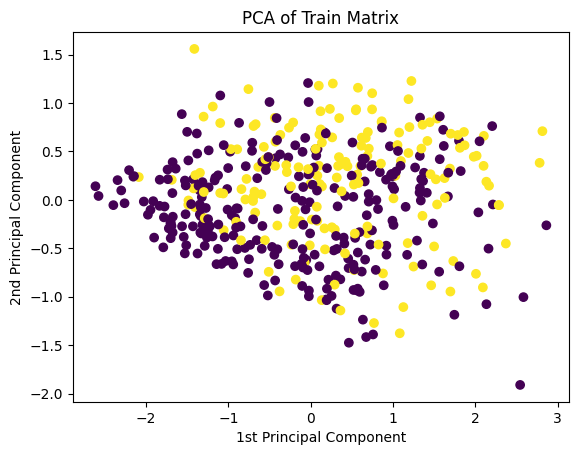

In [45]:
plt.Figure(figsize=(10,10))
fig = plt.scatter(train_pca_matrix[:,0], train_pca_matrix[:,1], c=train_target)
plt.title('PCA of Train Matrix')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

## Classifying based on the PCA Data Matrix

In [46]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(selected_train_matrix)
train_pca_matrix = pca.transform(selected_train_matrix)
test_pca_matrix = pca.transform(selected_test_matrix)
print(train_pca_matrix.shape)
print(test_pca_matrix.shape)

(436, 30)
(109, 30)


--------------------------------------------------
Training set based on PCA
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       270
         1.0       0.72      0.65      0.69       166

    accuracy                           0.77       436
   macro avg       0.76      0.75      0.75       436
weighted avg       0.77      0.77      0.77       436



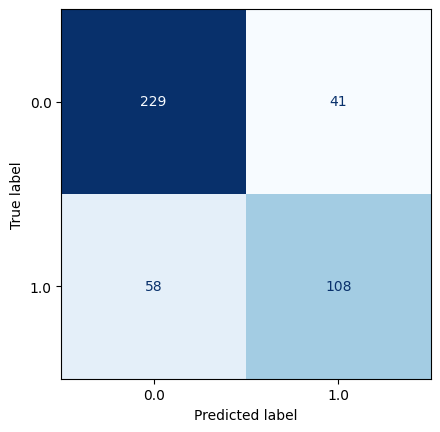

--------------------------------------------------
Test set based on PCA
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76        63
         1.0       0.68      0.54      0.60        46

    accuracy                           0.70       109
   macro avg       0.69      0.68      0.68       109
weighted avg       0.69      0.70      0.69       109



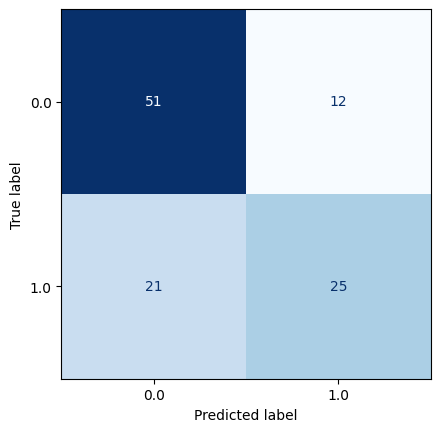

In [50]:
model = LinearDiscriminantAnalysis()
# model = QuadraticDiscriminantAnalysis()
# model = GaussianNB()
model.fit(train_pca_matrix, train_target)
train_pred = model.predict(train_pca_matrix)
test_pred = model.predict(test_pca_matrix)
print('-'*50)
print('Training set based on PCA')
print(classification_report(train_target, train_pred))

ConfusionMatrixDisplay.from_predictions(train_target, train_pred, cmap='Blues', colorbar=False)
plt.show()

print('-'*50)
print('Test set based on PCA')
print(classification_report(test_target, test_pred))
ConfusionMatrixDisplay.from_predictions(test_target, test_pred, cmap='Blues', colorbar=False)
plt.show()

--------------------------------------------------
Training set
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       270
         1.0       0.82      0.78      0.80       166

    accuracy                           0.85       436
   macro avg       0.84      0.84      0.84       436
weighted avg       0.85      0.85      0.85       436



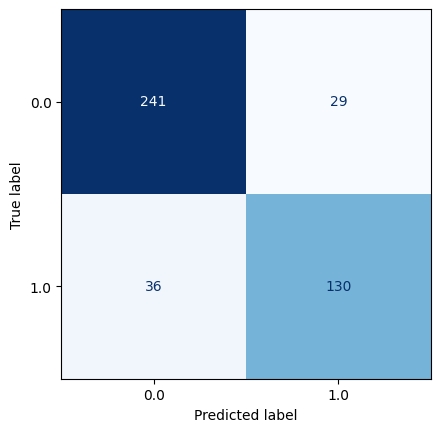

--------------------------------------------------
Test set
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77        63
         1.0       0.70      0.61      0.65        46

    accuracy                           0.72       109
   macro avg       0.72      0.71      0.71       109
weighted avg       0.72      0.72      0.72       109



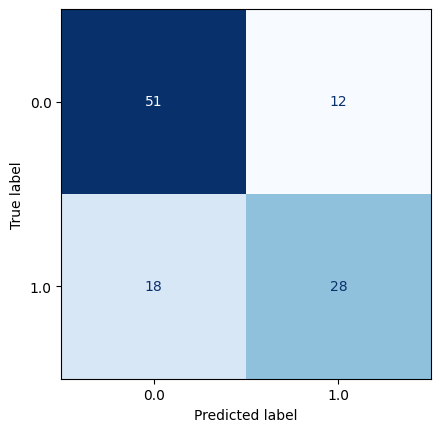

In [57]:
model = LinearDiscriminantAnalysis()
# model = QuadraticDiscriminantAnalysis()
# model = GaussianNB()
# model = SVC(kernel='linear')
model.fit(selected_train_matrix, train_target)
train_pred = model.predict(selected_train_matrix)
test_pred = model.predict(selected_test_matrix)
print('-'*50)
print('Training set')
print(classification_report(train_target, train_pred))

ConfusionMatrixDisplay.from_predictions(train_target, train_pred, cmap='Blues', colorbar=False)
plt.show()

print('-'*50)
print('Test set')
print(classification_report(test_target, test_pred))
ConfusionMatrixDisplay.from_predictions(test_target, test_pred, cmap='Blues', colorbar=False)
plt.show()

## Saving Result

In [49]:
dir_path = 'D:/VSCodes (Saeed)/Prostate Cancer Project (Metastasis Status)(mRNA)/Feature_Selection_Step/'
file_name = 'Selected Features (3rd step)'
save_object(selected_mRNA_id, dir_path, file_name)

'D:\\VSCodes (Saeed)\\Prostate Cancer Project (Metastasis Status)(mRNA)\\Feature_Selection_Step\\Selected Features (3rd step).pkl'